In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from google.colab import drive
import os
from IPython.display import HTML

In [2]:
drive.mount('/content/gdrive/')
os.chdir("/content/gdrive/MyDrive/DISSERTATION")
print(os.listdir())

Mounted at /content/gdrive/
['simple_hilbert.py', 'advection_block.py', '__pycache__', 'CAE_on_structured_mesh.ipynb', 'Flowpast', 'csv_data', 'animation.mp4', 'MeshCNN', 'fpc.obj', 'cache', 'fpc_000.npz', 'fpc.edges', 'fpc_000.npz (Unzipped Files)', 'Advection_of_a_block_over_structured_mesh.ipynb', 'Diss.ipynb']


In [3]:
#Creating a vertices array to store the x,y coords of the mesh
vertices = []

#Obj files are a list of vertices and faces
file = open("fpc.obj")

#Skipping the first line (which is just a tag)
for line in file.readlines()[1:]:
  if line[0]=="v": #For all lines that begin with a "v" and are vertices
    vertices.append([float(line.split(" ")[1]),float(line.split(" ")[2])]) #Add them to the array
  else:
    break

#Making it into a numpy array
vertices = np.array(vertices)

In [4]:
#Opening the data file for velocities.
vels = open("./csv_data/data_11.csv")
velocities = np.loadtxt(vels, delimiter=",")[:,3]



In [5]:
#Just to check
print(velocities)
print(vertices)

[0.03912551 0.03906223 0.03902747 ... 0.03966909 0.03968268 0.03991484]
[[0.02025602 0.41      ]
 [0.01552185 0.40350375]
 [0.01003644 0.41      ]
 ...
 [0.05027157 0.39993408]
 [0.05204738 0.41      ]
 [0.06215101 0.40337493]]


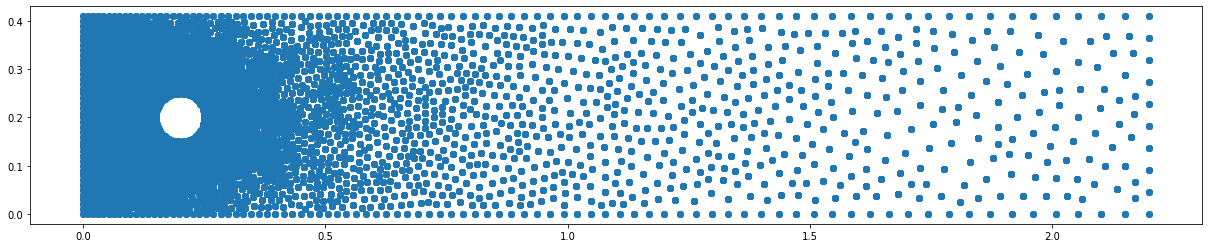

In [6]:
#Plotting the vertices just out of curiosity
fig = plt.figure(figsize=(21, 4))
plt.scatter(vertices[:,0], vertices[:,1])

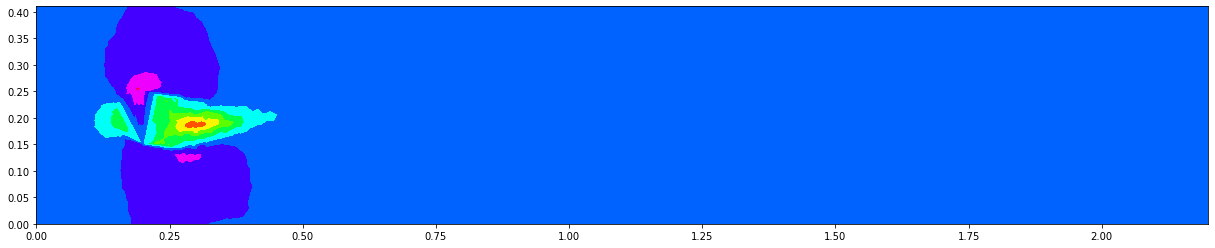

In [7]:
#Plotting tricontour, the cylinder is not very visible but it can be seen if you squint your eyes
fig = plt.figure(figsize=(21, 4))
plt.tricontourf(vertices[:,0], vertices[:,1],velocities, cmap = "hsv")

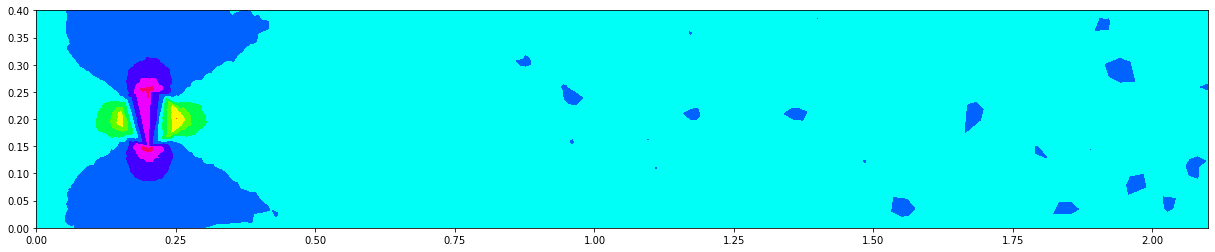

In [ ]:
#Animation function to see that I have correctly interpreted the velocity column as being in the same order as the vertices in the .obj
fig2 = plt.figure(figsize=(21, 4))
ax = plt.axes(xlim=(0, 2.1), ylim=(0, 0.4))

def animate(i):
    vels = open("./csv_data/data_" + str(i+1) + ".csv")
    velocities = np.loadtxt(vels, delimiter=",")[:,3]
    frame = plt.tricontourf(vertices[:,0], vertices[:,1], velocities, cmap = "hsv")
    return frame

anim = animation.FuncAnimation(fig2, animate, frames=200)

#You can check this in the folder as well
anim.save('animation.mp4')

In [8]:
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision
from torch.utils.data import DataLoader

In [13]:
#Importing a bunch of stuff from MeshCNN
os.chdir("./MeshCNN")
import models
import options.train_options
os.chdir("./models")
import networks
os.chdir("./layers")
import mesh
import mesh_pool

In [30]:
os.chdir("../../../")

In [18]:
opt = options.train_options.TrainOptions()

In [26]:
!opt.parse() --dataroot datasets/human_seg_compression/ \
--name human_seg \
--arch meshunet-compression \
--dataset_mode compression \
--ncf 16 16 32 32 32 \
--ninput_edges 2280 \
--pool_res 1200 600 300 220 \
--resblocks 0 \
--batch_size 24 \
--lr 0.001 \
--num_aug 1 \
--slide_verts 0 \
--gpu_ids -1 \

/bin/bash: -c: line 0: syntax error near unexpected token `--dataroot'
/bin/bash: -c: line 0: `opt.parse() --dataroot datasets/human_seg_compression/ --name human_seg --arch meshunet-compression --dataset_mode compression --ncf 16 16 32 32 32 --ninput_edges 2280 --pool_res 1200 600 300 220 --resblocks 0 --batch_size 24 --lr 0.001 --num_aug 1 --slide_verts 0 --gpu_ids -1 '


In [27]:
#This is literally a placeholder until I figure out the opt class from MeshCNN, to create a "Mesh" class you need an option class for data augmentation purposes, couldn't be bothered to learn it in time
class opt:
  num_aug = 1

In [31]:
#Creating my flow past cylinder mesh
fpcmesh = mesh.Mesh("fpc.obj",opt=opt)

In [68]:
fpcmesh2 = mesh.Mesh("fpc2.obj",opt=opt)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [32]:
#It has 20550 edges
fpcmesh.edges_count

20550

In [33]:
#And we have 20550 velocities.
print(len(velocities))

20550


In [34]:
#This is an encoder with 0 pooling operations that has two convolutions from 1 to 3 channels and from 3 to 6 channels.
enc = networks.MeshEncoder([1,1],[1,3,6])

In [35]:
enc

MeshEncoder(
  (convs): ModuleList(
    (0): DownConv(
      (conv1): MeshConv(
        (conv): Conv2d(1, 3, kernel_size=(1, 5), stride=(1, 1))
      )
      (bn): ModuleList(
        (0): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (pool): MeshPool()
    )
    (1): DownConv(
      (conv1): MeshConv(
        (conv): Conv2d(3, 6, kernel_size=(1, 5), stride=(1, 1))
      )
      (bn): ModuleList(
        (0): InstanceNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
  )
)

In [ ]:
#For the life of me, I cannot understand how the hell pooling operations work

In [36]:
velx = torch.Tensor(np.array([[velocities]]))

In [37]:
velx.shape

torch.Size([1, 1, 20550])

In [38]:
velx3 = enc([velx,[fpcmesh]])

IndexError: ignored

In [ ]:
print(velx3[0].size())

#As you can see we now have 6 channels after two convolution operations

torch.Size([1, 6, 20550])


In [39]:
print(velx3[0])

NameError: ignored

In [40]:
meshize = mesh_pool.MeshPool(18000)

In [41]:
meshize.forward(velx,[fpcmesh])

IndexError: ignored

In [42]:
def has_boundaries(mesh, edge_id):
      for edge in mesh.gemm_edges[edge_id]:
          if edge == -1 or -1 in mesh.gemm_edges[edge]:
              return True
      return False


def __pool_edge(self, mesh, edge_id, mask, edge_groups):
        if has_boundaries(mesh, edge_id):
            return False
        elif self.__clean_side(mesh, edge_id, mask, edge_groups, 0)\
            and self.__clean_side(mesh, edge_id, mask, edge_groups, 2) \
            and self.__is_one_ring_valid(mesh, edge_id):
            self.__merge_edges[0] = self.__pool_side(mesh, edge_id, mask, edge_groups, 0)
            self.__merge_edges[1] = self.__pool_side(mesh, edge_id, mask, edge_groups, 2)
            mesh.merge_vertices(edge_id)
            mask[edge_id] = False
            MeshPool.__remove_group(mesh, edge_groups, edge_id)
            mesh.edges_count -= 1
            return True
        else:
            return False

In [43]:
for i in range(20550):
  if has_boundaries(fpcmesh,i) == False:
    print(i)

In [57]:
#Creating my adobe example mesh
adobemesh = mesh.Mesh("adobe.obj",opt=opt)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [44]:
print(np.shape(fpcmesh.gemm_edges))

(20550, 4)


In [58]:
print(np.shape(adobemesh.gemm_edges))

(2250, 4)


In [59]:
print(fpcmesh.edges)

[[    0     1]
 [    1     2]
 [    0     2]
 ...
 [20547 20548]
 [20548 20549]
 [20547 20549]]


In [60]:
print(adobemesh.edges)

[[111 683]
 [111 684]
 [683 684]
 ...
 [366 367]
 [ 99 118]
 [131 718]]


In [62]:
print(fpcmesh.gemm_edges)

[[    1     2    -1    -1]
 [    2     0    -1    -1]
 [    0     1    -1    -1]
 ...
 [20548 20549    -1    -1]
 [20549 20547    -1    -1]
 [20547 20548    -1    -1]]


In [71]:
print(fpcmesh2.gemm_edges[10:20])

[[   7    9  712  713]
 [  12   13  454  439]
 [  13   11 4098 3622]
 [  11   12 9646 9645]
 [  15   16  413  458]
 [  16   14  613  767]
 [  14   15   -1   -1]
 [  18   19 8524 8522]
 [  19   17   -1   -1]
 [  17   18 4004 4003]]


In [83]:
edges = 0
for i in range(len(fpcmesh2.gemm_edges)):
  if fpcmesh2.gemm_edges[i][2] == -1 or fpcmesh2.gemm_edges[i][3] == -1:
    edges+=1
print(edges)

292


In [61]:
print(adobemesh.gemm_edges)

[[   1    2   21   20]
 [   2    0 1680   11]
 [   0    1 1077 1636]
 ...
 [ 899 2246  917  919]
 [ 326  314  670  275]
 [2206  278  665 1978]]


In [63]:
meshize2 = mesh_pool.MeshPool(1200)

In [ ]:
fpcmesh.edges_count

20550

In [ ]:
print(len(queue))

20550


In [ ]:
value, edge_id = heappop(queue)
print(value,edge_id)

2.1550321527286087e-09 20384.0


In [ ]:
print(velx2[0][0][0]-velx)

tensor([[[-0.0391, -0.0391, -0.0390,  ..., -0.0397, -0.0397, -0.0399]]],
       grad_fn=<SubBackward0>)


In [ ]:
def save_new_edges(filename):
    fpcmesh = mesh.Mesh(filename,opt=opt)
    edges = np.array(fpcmesh.edges)
    edge_file = filename.replace('.obj', '.edges')
    np.savetxt(edge_file, edges, fmt='%d')

In [ ]:
save_new_edges("fpc.obj")

In [ ]:
class GAE(nn.Module): 
  def __init__(self, dims_latent = 16):
    '''
    Class contains the Encoder (snapshot -> latent).
    '''

    super(two_D_Encoder, self).__init__()
    self.activate = nn.ReLU()
    self.c1 = nn.Conv2d(1, 2, kernel_size=5, stride= 2, padding=2) 
    self.c2 = nn.Conv2d(2, 4, kernel_size=5, stride= 2, padding=2)
    self.fc5 = nn.Linear(1024, 256)
    self.fc6 = nn.Linear(256, 64)

  def forward(self, x):  # Custom pytorch modules should follow this structure 
    '''
    x: [float] the block-advection snapshot
    '''

    x = x.unsqueeze(1).view(-1, 1, 128, 128) # Reshape the input into a image (1D to 2D) 
    x = self.activate(self.c1(x))
    x = self.activate(self.c2(x)) 
    x = self.activate(self.c3(x))
    x = self.activate(self.fc7(x))
    return x